# 2. Cleaning and Statistical EDA
Now that we've scraped our data, we need to go through it and clean it. In this notebook, we'll first clean our data, before analyzing summary statistics. We start by importing the usual suspects as well as reading in our newly formed .csv file:

**Please also type in the following command line/terminal installations**:

**For Interactive Visualizations for Jupyter Notebooks:**
* `pip install "notebook>=5.3" "ipywidgets>=7.2"`

**For Interactive Visualizations for Jupyter Labs:**
* Install node @ https://nodejs.org/en/, then in command line/terminal:
* `pip install jupyterlab "ipywidgets>=7.5"`
* `jupyter labextension install jupyterlab-plotly@4.8.2`

Source: https://plotly.com/python/getting-started/?utm_source=mailchimp-jan-2015&utm_medium=email&utm_campaign=generalemail-jan2015&utm_term=bubble-chart

**For Interactive EDA Pandas Profiling Report for Jupyter:**
* `pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip`

In [1]:
#Standard Python DS imports:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#set column size to be larger
pd.set_option("display.max_colwidth", 1000)

In [2]:
#we're going to use RegEx to clean so we import that too
import re

In [3]:
#We will then be importing these libraries: 

from plotly import __version__
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

print(__version__)
#learnt this from 
#https://towardsdatascience.com/interactive-distribution-plots-with-plotly-ea58efc78885

import cufflinks as cf
#we have to make sure this code is run for Jupyter Notebooks otherwise the plots may not happen:

init_notebook_mode(connected=True)

#we have to make sure this code is run otherwise the visualizations won't run offline:
cf.go_offline()

4.8.1


In [4]:
#pandas profiling imports
import pandas_profiling
from pandas_profiling import ProfileReport

import matplotlib.image as mpimg


In [5]:
#import our saved .csv file
df = pd.read_csv("../data/df_merged.csv", index_col=0)

In [6]:
df

,clause_text,clause_type
0,"Automatic Renewal. Upon the expiration of the original term or any renewal term of employment, Employee’s employment shall be automatically renewed for a one (1) year period unless, at least sixty (60) days prior to the renewal date, either party gives the other party written notice of its intent not to continue the employment relationship. During any renewal term of employment, the terms, conditions and provisions set forth in this Agreement shall remain in effect unless modified in accordance with Section 8.",automatic_renewal_clause
1,"Automatic Renewal. This Agreement shall be automatically extended for one additional year, unless on or before November 30, 2007 (for the initial term), or thirteen (13) months before the expiration of any extended term, either Party provides to the other written notice of its desire not to automatically renew this Agreement.",automatic_renewal_clause
2,"Automatic Renewal. This Agreement shall renew automatically, with respect to each series set forth in Schedule A, on the same terms, for a period of one year from the expiration of the waiver and/or expense commitment applicable to such series as set forth in Schedule A, unless prior to such an expiration, CMA and/or CMD provide notice to the appropriate Board of Trustees of a Company of any proposals to increase, decrease or eliminate the series’ fee waivers and/or expense commitment, or to change the time period covered or any other terms thereof, for a subsequent period. Any renewal of this Agreement with respect to a series does not preclude CMA or CMD from requesting that a Company’s Board of Trustees approve changes to the fee waivers and/or expense commitment, or to the time period covered or any other terms thereof, prior to a subsequent renewal.",automatic_renewal_clause
3,"Automatic Renewal. If a Holder of such Security has not delivered a Repayment Election for repayment of the Security on or prior to the 15th day following the Maturity Date, and the Company did not notify the Holder of its intention to repay the Security in the Notice of Maturity, then such maturing Security shall be extended automatically for an additional term equal to the original term, and shall be deemed to be renewed by the Holder and the Company as of the Maturity Date of such maturing Security. A maturing Security will continue to renew as described herein absent a Redemption Notice or Repurchase Request by the Holder or an indication by the Company that it will repay and not allow the Security to be renewed in the Notice of Maturity. Interest on the renewed Security shall accrue from the Issue Date thereof, which is the first day of such renewed term (i.e., the Maturity Date of the maturing Security). Such renewed Security will be deemed to have the identical terms and pro...",automatic_renewal_clause
4,Automatic Renewal. This Agreement shall be renewed automatically for succeeding terms of three (3) years each unless either party gives written notice to the other at least ninety (90) days prior to the expiration of any term of Executive’s or Company’s intention not to renew pursuant to Company’s bylaws.,automatic_renewal_clause
...,...,...
9881,"Compliance with Law. In the performance of such services as described herein, the Insurer shall comply with applicable laws, rules and regulations.",other_clauses
9882,Compliance with Law. It shall comply with all applicable laws relating to its performance under this Agreement.,other_clauses
9883,"Compliance with Law. JCR agrees to comply with all applicable laws, rules and regulations with respect to Product for use in the Field in the Territory.",other_clauses
9884,"Compliance with Law. Landlord and Tenant shall each do all acts necessary to comply with all applicable laws, statutes, ordinances, and rules of any public authority relating to their respective maintenance obligations as set forth herein. The provisions of Section 9.2. are deemed restated here.",other_clauses


### Redundant Captions

The first problem we have is the redundant first sentence. All our clauses are scraped
with the first sentence effectively acting as a caption that we should remove 
this will prevent over-simplifying the weights of our text classifier model.

In [7]:
#We can write a regex-matching function to delete the first sentence of each clause like so:

def clean_text(mess):
    new_text = re.sub("^.*?[\.!\?](?:\s|$)", '', mess)
    return new_text

In [8]:
#we then apply it to all of our clauses:
df["clause_text"] = df["clause_text"].apply(clean_text)

In [9]:
#the function worked.
df.head(3)

,clause_text,clause_type
0,"Upon the expiration of the original term or any renewal term of employment, Employee’s employment shall be automatically renewed for a one (1) year period unless, at least sixty (60) days prior to the renewal date, either party gives the other party written notice of its intent not to continue the employment relationship. During any renewal term of employment, the terms, conditions and provisions set forth in this Agreement shall remain in effect unless modified in accordance with Section 8.",automatic_renewal_clause
1,"This Agreement shall be automatically extended for one additional year, unless on or before November 30, 2007 (for the initial term), or thirteen (13) months before the expiration of any extended term, either Party provides to the other written notice of its desire not to automatically renew this Agreement.",automatic_renewal_clause
2,"This Agreement shall renew automatically, with respect to each series set forth in Schedule A, on the same terms, for a period of one year from the expiration of the waiver and/or expense commitment applicable to such series as set forth in Schedule A, unless prior to such an expiration, CMA and/or CMD provide notice to the appropriate Board of Trustees of a Company of any proposals to increase, decrease or eliminate the series’ fee waivers and/or expense commitment, or to change the time period covered or any other terms thereof, for a subsequent period. Any renewal of this Agreement with respect to a series does not preclude CMA or CMD from requesting that a Company’s Board of Trustees approve changes to the fee waivers and/or expense commitment, or to the time period covered or any other terms thereof, prior to a subsequent renewal.",automatic_renewal_clause


### Null Values

We can quickly use a heatmap to see how bad the null values are (in yellow lines) within our targeted dataframe.

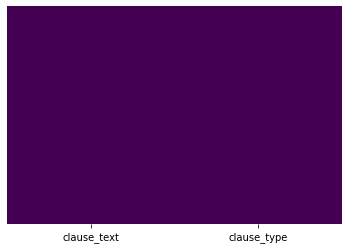

In [10]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

#we apparently have no null values. That's great.

### Duplicate Row Fixing
We checking for duplicate rows since web scraping is not always a perfect science.

In [11]:
duplicate_rows = df[df.duplicated(['clause_text'])] #call mask on "clause_text" since thats unique
print(duplicate_rows)

     clause_text            clause_type
737               renewal_option_clause
2191                      other_clauses
2192                      other_clauses
2254                      other_clauses
2487                      other_clauses
2673                      other_clauses
2896                      other_clauses
2897                      other_clauses
2899                      other_clauses
2900                      other_clauses
4118                      other_clauses
4686                      other_clauses
5007                      other_clauses
5008                      other_clauses
6277                      other_clauses
9094                      other_clauses


In [12]:
#seems we have quite a few duplicate rows. What do they look like?
duplicate_rows

,clause_text,clause_type
737,,renewal_option_clause
2191,,other_clauses
2192,,other_clauses
2254,,other_clauses
2487,,other_clauses
2673,,other_clauses
2896,,other_clauses
2897,,other_clauses
2899,,other_clauses
2900,,other_clauses


In [13]:
#they're all blank fields which don't count as null values. 
#This is because each of these register as blank spaces, e.g.:
df["clause_text"][9094]

''

In [14]:
#we'll remove all of these rows using the pandas drop duplicate function:
df.drop_duplicates(subset ="clause_text", keep = False, inplace = True)

In [15]:
#double checking if there are any duplicate rows - and there are none.
duplicate_rows = df[df.duplicated(['clause_text'])] #call mask on "clause_text" since thats unique
print(duplicate_rows)

Empty DataFrame
Columns: [clause_text, clause_type]
Index: []


In [16]:
#we backup our dataframe again
df.to_csv("../data/df_clean_draft.csv")

### Insubstantially Scraped Clauses
Some of the clauses that were scraped lack any real substance. For instance:

* There are clause texts that simply say `"deleted"`, which isn't very helpful.
* Some clauses are graphical errors that only contain symbols or numbers and nothing else.
* Some clauses are too short and only contain 4 words or less. 

In [17]:
#We can write a function that counts the number of words per clause
#it tells us there is a fair number of rows with very few words that we have to remove.

count = df['clause_text'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
count

0 words:       80
1 words:       49
10 words:       3
100 words:     47
1000 words:    30
               ..
995 words:     22
996 words:      5
997 words:     23
998 words:     10
999 words:     18
Name: clause_text, Length: 9869, dtype: int64

In [18]:
#we display more rows because we want to see a larger chunk of our unwanted rows:
pd.set_option('display.max_rows', 150)

In [19]:
#we create an object that lets us see our lousy clause texts
#in this case, text with less than 6 words isn't deemed to be of value:
insubstantial_clauses = df[df['clause_text'].str.split().str.len() < 6]  

In [20]:
insubstantial_clauses.shape

(121, 2)

In [21]:
#let's go through what clauses with less than 6 words look like. 
#we see quite easily that they aren't really true clauses
#they look more like appendix notes, edits and titles/captions rather than true clauses.

insubstantial_clauses.head(121)

,clause_text,clause_type
10,Automatic Renewal deleted],automatic_renewal_clause
83,Not applicable.,automatic_renewal_clause
87,See Attached Rider.,automatic_renewal_clause
347,Defined in Section 48.A hereof.,renewal_option_clause
348,Defined in Subsection 48.A. hereof.,renewal_option_clause
349,Deleted.,renewal_option_clause
367,INDUSTRIAL.THERMADYNE.CONTRATOARRENDAMIENTO.MP.30.10.08,renewal_option_clause
540,See Exhibit D attached hereto.,renewal_option_clause
742,Renewal Option,renewal_option_clause
744,For purposes of this Agreement:,other_clauses


In [22]:
#we drop these insubstantial texts from the rest of our dataframe
df = df.drop(insubstantial_clauses.index)

In [23]:
df.shape

(9748, 2)

In [24]:
#with regex let's just double check to make sure none of the rows are just a bunch of symbols
#we create a dataframe that finds rows which match strings where there aren't any alphanumerics
pure_symbols_only = df[df['clause_text'].str.match('^\W+$')]

In [25]:
#so we have 2 rows that need to be cleaned out which for whatever reason are just full stops
pure_symbols_only

,clause_text,clause_type
5883,. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .,other_clauses
7826,. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .,other_clauses


In [26]:
#we drop this too of course
df = df.drop(pure_symbols_only.index)

In [27]:
df.shape

(9746, 2)

In [28]:
#let's also create a new column to count no. of words in clause text
#the regex match here will look for all words, and then count how many of them there are

df['clause_word_count'] = df['clause_text'].str.findall(r'(\w+)').str.len()

In [29]:
df.head(3)

,clause_text,clause_type,clause_word_count
0,"Upon the expiration of the original term or any renewal term of employment, Employee’s employment shall be automatically renewed for a one (1) year period unless, at least sixty (60) days prior to the renewal date, either party gives the other party written notice of its intent not to continue the employment relationship. During any renewal term of employment, the terms, conditions and provisions set forth in this Agreement shall remain in effect unless modified in accordance with Section 8.",automatic_renewal_clause,81
1,"This Agreement shall be automatically extended for one additional year, unless on or before November 30, 2007 (for the initial term), or thirteen (13) months before the expiration of any extended term, either Party provides to the other written notice of its desire not to automatically renew this Agreement.",automatic_renewal_clause,49
2,"This Agreement shall renew automatically, with respect to each series set forth in Schedule A, on the same terms, for a period of one year from the expiration of the waiver and/or expense commitment applicable to such series as set forth in Schedule A, unless prior to such an expiration, CMA and/or CMD provide notice to the appropriate Board of Trustees of a Company of any proposals to increase, decrease or eliminate the series’ fee waivers and/or expense commitment, or to change the time period covered or any other terms thereof, for a subsequent period. Any renewal of this Agreement with respect to a series does not preclude CMA or CMD from requesting that a Company’s Board of Trustees approve changes to the fee waivers and/or expense commitment, or to the time period covered or any other terms thereof, prior to a subsequent renewal.",automatic_renewal_clause,149


In [30]:
#that's all the cleaning we need initially.
#we back things up once again
df.to_csv("../data/df_clean_draft_1.csv")

## Statistical EDA and Visualizations

We will now go conduct exploratory data analysis of our statistical data, with visualizations. We start with basic chart visualizations. 

We will then move on to more NLP-specific visualizations in our next notebook.

**What are the overall summary statistics for our dataset?**

In [31]:
#this is where we run Pandas Profiling - this is a custom library
#it summarizes statistical data for us
profile = ProfileReport(df, title='Clauses Dataframe Pandas Profiling Report', explorative=True)

In [32]:
profile

**What is the distribution of our clauses?**

In [42]:
px.histogram(data_frame=df, x="clause_type", 
             title="Clause Distribution, by Clause Type") 

#plots histograms and boxplots of datascience and analytics
#learnt this from https://plotly.com/python/histograms/

**What's the distribution of clause word length for each clause type?**

In [43]:
px.histogram(data_frame=df, x="clause_word_count", color="clause_type", 
             marginal="box", title="Histogram and Boxplot of Clause Word Count Distribution, by Clause Type") 

In [44]:
df.groupby(["clause_type"])[["clause_word_count"]].describe().T

clause_type              automatic_renewal_clause  other_clauses  \
clause_word_count count                156.000000    9014.000000   
                  mean                  77.461538     120.223541   
                  std                   52.475295     105.381769   
                  min                    7.000000       1.000000   
                  25%                   45.000000      42.000000   
                  50%                   63.000000      87.000000   
                  75%                   94.500000     161.000000   
                  max                  433.000000     455.000000   

clause_type              renewal_option_clause  
clause_word_count count             576.000000  
                  mean              101.265625  
                  std                97.635082  
                  min                 7.000000  
                  25%                37.000000  
                  50%                66.000000  
                  75%               128.000000  
                  max               448.000000

## Interpretation of Statistical EDA and Visualizations:
1. **Summary Stats**: Although the pandas profiling report is visually accessible, it honestly doesn't tell us too much. The main takeaway from it is that we have 9746 different unique clauses. It seems pandas profiling is not geared towards NLP-specific summarization anyway.


2. **Clause Types**: The histogram shows that there are 9,014 `other clauses` vs 576 `renewal option clauses` and only 156 `automatic renewal clauses`. Both renewal clauses are our target, so it's only logical that really only going after the prediction of 2 types of clauses out of an entire contract filled with other clauses will mean that **our target prediction clauses are going to be in a minority class**. 

    What this means for us, though is that we will need to utilize some sort of over-sampling/under-sampling mechanism like SMOTE before modelling to account for this imbalance.


2. **Clause Word Count**: For all clause types, we see that the distribution is heavily skewed right/left leaning. Visually, we see that most clauses tend to have fewer than 200 words.
    
    For `automatic renewal clauses`, we see that the interquartile range ("IQR") is 49.5 words; for `renewal option clauses`, the IQR tends to be longer at 91 words. 
    
    For `other clauses`, because these are by definition any other type of contract clause, the word count on any statistical metric is far larger: the mean itself is already 120 words, and it has an IQR of 119 words. What's also interesting is that the word count distribution is **bimodal** i.e. we have a significant minority of `other clauses` that range between ~350-450 words, as is visually observable by the second peak around that range in the visualization above.

So far we've only looked at the statistics and not the words. We now turn to more NLP-specific visualizations in our next notebook.